In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
src = "/home/andres/data/hbmep-processed/J_SHAP/data.csv"
df = pd.read_csv(src)

In [3]:
df.shape

(16440, 44)

In [4]:
columns = ["part"]

In [5]:
df.columns

Index(['pulse_amplitude', 'pulse_train_frequency', 'pulse_period',
       'pulse_duration', 'pulse_count', 'train_delay', 'channel1_1',
       'channel1_2', 'channel1_3', 'channel1_4', 'channel2_1', 'channel2_2',
       'channel2_3', 'channel2_4', 'charge_params_1', 'charge_params_2',
       'charge_params_3', 'charge_params_4', 'bank_check', 'run', 'enabled',
       'channel_failA', 'channel_failB', 'channel_fail_comb', 'time_pulse',
       'time', 'ix_onsets', 'auc_2', 'auc_6', 'auc_5', 'auc_7', 'auc_1',
       'auc_4', 'auc_3', 'auc_8', 'channel1_laterality', 'channel1_segment',
       'channel2_laterality', 'channel2_segment', 'compound_position',
       'compound_charge_params', 'participant', 'subdir_pattern',
       'charge_param_error'],
      dtype='object')

In [6]:
file = open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl","rb")
combo = pickle.load(file)

In [7]:
combo.keys()

dict_keys([('amap01', 'C7M-C7L', '50-0-50-100', 'LADM'), ('amap01', 'C7M-C7L', '50-0-50-100', 'LBiceps'), ('amap01', 'C7M-C7L', '50-0-50-100', 'LDeltoid'), ('amap01', 'C7M-C7L', '50-0-50-100', 'LECR'), ('amap01', 'C7M-C7L', '50-0-50-100', 'LFCR'), ('amap01', 'C7M-C7L', '50-0-50-100', 'LTriceps'), ('amap01', 'C7L-', '20-0-80-25', 'LADM'), ('amap01', 'C7L-', '20-0-80-25', 'LBiceps'), ('amap01', 'C7L-', '20-0-80-25', 'LDeltoid'), ('amap01', 'C7L-', '20-0-80-25', 'LECR'), ('amap01', 'C7L-', '20-0-80-25', 'LFCR'), ('amap01', 'C7L-', '20-0-80-25', 'LTriceps'), ('amap01', 'C8L-C7L', '50-0-50-100', 'LADM'), ('amap01', 'C8L-C7L', '50-0-50-100', 'LBiceps'), ('amap01', 'C8L-C7L', '50-0-50-100', 'LDeltoid'), ('amap01', 'C8L-C7L', '50-0-50-100', 'LECR'), ('amap01', 'C8L-C7L', '50-0-50-100', 'LFCR'), ('amap01', 'C8L-C7L', '50-0-50-100', 'LTriceps'), ('amap01', 'C8L-C8M', '50-0-50-100', 'LADM'), ('amap01', 'C8L-C8M', '50-0-50-100', 'LBiceps'), ('amap01', 'C8L-C8M', '50-0-50-100', 'LDeltoid'), ('amap0

In [8]:
def threshold_array(shape):
    my_dict = {
    (key[0], key[1], key[3]): value["a"].mean() for  key,value in combo.items() if key[2] == shape
    }
    keys, values = zip(*my_dict.items())
    axis0 = np.unique([key[0] for key in keys])
    axis1 = ["Deltoid", "Biceps", "Triceps", "ECR", "FCR", "ADM"][::-1]
    pos_L = np.zeros((len(axis0), len(axis1)))
    pos_M = np.zeros((len(axis0), len(axis1)))
    for key, value in zip(keys, values):
        if key[1].split("-")[0][2:] == "L":
            pos_L[np.where(axis0 == key[0])[0], np.where(np.array(axis1) == key[2][1:])[0]] = 1/value 
        elif key[1].split("-")[0][2:] == "M":
            pos_M[np.where(axis0 == key[0])[0], np.where(np.array(axis1) == key[2][1:])[0]] = 1/value 
    return(pos_L, pos_M, axis0, axis1)

In [9]:
arr = None
responses = list(set([u[3] for u in combo.keys()]))
combinations_no_response = [(c[0], c[1], c[2]) for c in combo]
combinations_no_response = set(combinations_no_response)
combinations_no_response = list(combinations_no_response)
for muscle in responses:
    arr_muscle = None

    for c in combinations_no_response:
        a = combo[(*c, muscle)]["a"]
        a = a[:, 0, 0, 0, 0]

        if arr_muscle is None:
            arr_muscle = a[:, None]
        else:
            # concatenate now
            arr_muscle = np.concatenate([arr_muscle, a[:, None]], axis=-1)

    if arr is None:
        arr = arr_muscle[:,:, None]

    else:
        arr = np.concatenate([arr, arr_muscle[:,:, None]], axis = -1) 

In [10]:
arr.shape

(4000, 320, 6)

In [11]:
combinations_no_response

[('amap04', '-C6L', '20-0-80-25'),
 ('amap06', 'C6L-C7L', '80-0-20-400'),
 ('amap05', 'C6L-C7L', '20-0-80-25'),
 ('amap08', 'C7L-C6L', '20-0-80-25'),
 ('amap01', 'C7L-', '20-0-80-25'),
 ('amap08', 'C7L-', '20-0-80-25'),
 ('amap06', 'C7L-', '50-0-50-0'),
 ('amap03', 'C8L-C7L', '50-0-50-0'),
 ('amap01', 'C8L-C8M', '50-0-50-0'),
 ('amap08', 'C6L-C6M', '80-0-20-400'),
 ('amap02', 'C8L-C7L', '80-0-20-400'),
 ('amap08', '-C7L', '50-0-50-0'),
 ('amap07', 'C7L-C6L', '50-0-50-100'),
 ('amap04', '-C7L', '20-0-80-25'),
 ('amap02', 'C7L-C7M', '50-0-50-0'),
 ('amap05', 'C7L-', '20-0-80-25'),
 ('amap05', 'C6L-C6M', '80-0-20-400'),
 ('amap07', 'C6L-C6M', '50-0-50-100'),
 ('amap05', 'C7M-C7L', '50-0-50-100'),
 ('amap03', 'C7M-C7L', '20-0-80-25'),
 ('amap02', 'C7L-C8L', '50-0-50-0'),
 ('amap05', 'C6M-C6L', '80-0-20-400'),
 ('amap06', 'C6L-', '80-0-20-400'),
 ('amap06', '-C6L', '20-0-80-25'),
 ('amap05', 'C7L-C6L', '50-0-50-0'),
 ('amap05', 'C6L-', '20-0-80-25'),
 ('amap08', 'C7M-C7L', '50-0-50-0'),
 ('

In [12]:
df[['participant','compound_position', 'compound_charge_params']].apply(tuple, axis = 1).nunique()

320

In [13]:
pmono20 = np.array([bool(re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
pmono80 = np.array([bool(re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
mono = np.array([bool(re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
bip = np.array([bool(re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

lat = np.array([bool(s[1].split("-")[1][2:] == "L") for s in combinations_no_response])
med = np.array([bool(s[1].split("-")[1][2:] == "M") for s in combinations_no_response])



In [14]:
dictBool = {}

dictBool[('lateral pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])
dictBool[('lateral pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])
dictBool[('lateral bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])
dictBool[('lateral mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "L") for s in combinations_no_response])

dictBool[('medial pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
dictBool[('medial pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
dictBool[('medial bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
dictBool[('medial mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and re.search(r'.+-.+', s[1]) and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])


In [15]:
A = arr[:,dictBool[('lateral pmono20')],:].mean(axis=0)

In [16]:
# A.reshape(-1,).shape

In [17]:
diplot = {}

diplot[('L-M pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])

diplot[('M-L pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])

diplot[('ground - position mono')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])
diplot[('position - ground mono')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

diplot[('ground - position p20')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
diplot[('position - ground p20')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])

diplot[('ground - position p80')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
diplot[('position - ground p80')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])

diplot[('ground - position bip')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
diplot[('position - ground bip')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])

In [18]:
A.mean()

159.82804525509843

In [19]:
stats.sem(A.reshape(-1,))

9.19492007716287

In [20]:
value = []
for b,v in dictBool.items():
    for b1, v1 in dictBool.items():
        A = arr[:,v,:].mean(axis = 0).reshape(-1,)
        B = arr[:,v1,:].mean(axis = 0).reshape(-1,)
        tbvs, pbvs = stats.ttest_ind(B,A, alternative="less")
        if pbvs < 0.05:
            value.append(f"{b1} is more effective than {b} (p = {pbvs})")
        else: value.append(f"No significant difference for {b1} vs {b} (p = {pbvs})")

In [21]:
A = arr[:,mono,:].mean(axis = 0).reshape(-1,)
B = arr[:,bip,:].mean(axis = 0).reshape(-1,)

tbvs, pbvs = stats.ttest_ind(B,A, alternative="less")

pbvs

0.9999996519248618

In [22]:
value

['No significant difference for lateral pmono20 vs lateral pmono20 (p = 0.5)',
 'No significant difference for lateral pmono80 vs lateral pmono20 (p = 0.24885073758223752)',
 'No significant difference for lateral bip vs lateral pmono20 (p = 0.13371095690032497)',
 'No significant difference for lateral mono vs lateral pmono20 (p = 0.7217150520969161)',
 'No significant difference for medial pmono20 vs lateral pmono20 (p = 0.997775474786967)',
 'No significant difference for medial pmono80 vs lateral pmono20 (p = 0.9884524148383962)',
 'No significant difference for medial bip vs lateral pmono20 (p = 0.6939039894212642)',
 'No significant difference for medial mono vs lateral pmono20 (p = 0.9999413360281021)',
 'No significant difference for lateral pmono20 vs lateral pmono80 (p = 0.7511492624177625)',
 'No significant difference for lateral pmono80 vs lateral pmono80 (p = 0.5)',
 'No significant difference for lateral bip vs lateral pmono80 (p = 0.339606902913121)',
 'No significant d

In [23]:
a = set(u[1] for u in combinations_no_response)
a

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [24]:
C61 = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C71 = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C81 = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C62 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C72 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C82 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C63 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C73 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C83 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C64 = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C6" in s[1].split("-")[0][0:] or "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C74 = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] or "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C84 = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C8" in s[1].split("-")[0][0:] or "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])

In [25]:
C = arr[:,C71,:].mean(axis = 0).reshape(-1,)
D = arr[:,C81,:].mean(axis = 0).reshape(-1,)

tbvs, pbvs = stats.ttest_ind(C,D, alternative="less")

pbvs

2.9022671961367066e-12

In [26]:
C74.sum()

48

Graphing if we want group comparison

In [27]:
def graph_arr(charge):
    L, M, subject, muscle = threshold_array(charge)
    sub_meanS = np.median(L, axis=0)
    rowS = np.vsplit(L,len(subject))
    rowS = [i.tolist() for i in rowS]
    sub_meanL = np.median(M, axis=0)
    rowL = np.vsplit(M,len(subject))
    rowL = [i.tolist() for i in rowL]
    for xval_ind, xval in enumerate(rowS):
        # plt.plot(xval[0], muscle, linestyle='dashed', marker=".", markersize=20, alpha =0.3, color = "pink")
        plt.plot(sub_meanS,muscle, color = "red", linestyle='dashed', marker=".", markersize=20, label="Lateral" if xval_ind == 0 else None)
        # plt.legend('Lateral')
    for xval_ind,xval in enumerate(rowL):
        # plt.plot(xval[0], muscle, linestyle='dashed', marker=".", markersize=25, alpha =0.3, color = "blue")
        plt.plot(sub_meanL,muscle, color = "black", linestyle='dashed', marker=".", markersize=20, label="Medial" if xval_ind == 1 else None)
        # plt.legend('Medial')
    plt.yticks(weight ='bold',style = 'italic')
    plt.xlabel('Efficacy')
    plt.legend()
    plt.show()
    

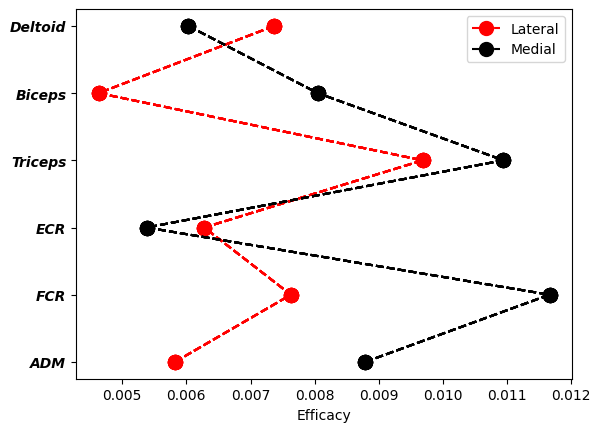

In [28]:
graph_arr("20-0-80-25")

## Rostral Caudal

In [29]:
a

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [30]:
C67b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87b = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C67m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87m = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C67p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87p80 = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C67p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C76p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

C78p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
C87p20 = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])


In [31]:
rost = arr[:,C67m,:].mean(axis = 0)

rost.shape

(5, 6)

In [32]:
np.sort(np.array(combinations_no_response)[C67m], axis=0)

array([['amap04', 'C6L-C7L', '50-0-50-100'],
       ['amap05', 'C6L-C7L', '50-0-50-100'],
       ['amap06', 'C6L-C7L', '50-0-50-100'],
       ['amap07', 'C6L-C7L', '50-0-50-100'],
       ['amap08', 'C6L-C7L', '50-0-50-100']], dtype='<U11')

In [33]:
t = np.array(combinations_no_response)[C76m]

t

array([['amap07', 'C7L-C6L', '50-0-50-100'],
       ['amap04', 'C7L-C6L', '50-0-50-100'],
       ['amap08', 'C7L-C6L', '50-0-50-100'],
       ['amap06', 'C7L-C6L', '50-0-50-100'],
       ['amap05', 'C7L-C6L', '50-0-50-100']], dtype='<U11')

In [34]:
np.matrix.argsort(t, axis=0)

array([[1, 0, 0],
       [4, 1, 1],
       [3, 2, 2],
       [0, 3, 3],
       [2, 4, 4]])

In [35]:
ind = np.argsort(t, axis=0)

In [36]:
np.take_along_axis(t, ind, axis=0)

array([['amap04', 'C7L-C6L', '50-0-50-100'],
       ['amap05', 'C7L-C6L', '50-0-50-100'],
       ['amap06', 'C7L-C6L', '50-0-50-100'],
       ['amap07', 'C7L-C6L', '50-0-50-100'],
       ['amap08', 'C7L-C6L', '50-0-50-100']], dtype='<U11')

In [37]:
t[np.matrix.argsort(t, axis=0)]

array([[['amap04', 'C7L-C6L', '50-0-50-100'],
        ['amap07', 'C7L-C6L', '50-0-50-100'],
        ['amap07', 'C7L-C6L', '50-0-50-100']],

       [['amap05', 'C7L-C6L', '50-0-50-100'],
        ['amap04', 'C7L-C6L', '50-0-50-100'],
        ['amap04', 'C7L-C6L', '50-0-50-100']],

       [['amap06', 'C7L-C6L', '50-0-50-100'],
        ['amap08', 'C7L-C6L', '50-0-50-100'],
        ['amap08', 'C7L-C6L', '50-0-50-100']],

       [['amap07', 'C7L-C6L', '50-0-50-100'],
        ['amap06', 'C7L-C6L', '50-0-50-100'],
        ['amap06', 'C7L-C6L', '50-0-50-100']],

       [['amap08', 'C7L-C6L', '50-0-50-100'],
        ['amap05', 'C7L-C6L', '50-0-50-100'],
        ['amap05', 'C7L-C6L', '50-0-50-100']]], dtype='<U11')

In [38]:
t = np.array(["C", "A", "B", "D"])

np.argsort(t)

array([1, 2, 0, 3])

In [39]:
np.sort(t)

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [40]:
t[np.argsort(t)]

array(['A', 'B', 'C', 'D'], dtype='<U1')

In [41]:
np.sort(np.array(combinations_no_response)[C76m], axis=0)


array([['amap04', 'C7L-C6L', '50-0-50-100'],
       ['amap05', 'C7L-C6L', '50-0-50-100'],
       ['amap06', 'C7L-C6L', '50-0-50-100'],
       ['amap07', 'C7L-C6L', '50-0-50-100'],
       ['amap08', 'C7L-C6L', '50-0-50-100']], dtype='<U11')

In [42]:
caud = arr[:,C76m,:].mean(axis = 0)
caud.shape

(5, 6)

In [43]:
np.sort(np.array(combinations_no_response)[C76m])


array([['50-0-50-100', 'C7L-C6L', 'amap07'],
       ['50-0-50-100', 'C7L-C6L', 'amap04'],
       ['50-0-50-100', 'C7L-C6L', 'amap08'],
       ['50-0-50-100', 'C7L-C6L', 'amap06'],
       ['50-0-50-100', 'C7L-C6L', 'amap05']], dtype='<U11')

In [44]:
rost.shape

(5, 6)

In [45]:
db = {}

db['C67b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C67m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87m'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C67p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87p80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C67p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C6" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C76p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C6" in s[1].split("-")[1][0:])) for s in combinations_no_response])

db['C78p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C7" in s[1].split("-")[0][0:] and "C8" in s[1].split("-")[1][0:])) for s in combinations_no_response])
db['C87p20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and ("C8" in s[1].split("-")[0][0:] and "C7" in s[1].split("-")[1][0:])) for s in combinations_no_response])

In [46]:
#L vs M
db['C67b'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])


In [47]:
"C5M" < "C6L" 

True

In [48]:
rost = arr[:,db['C76m'],:].mean(axis = 0)
rost.shape

(5, 6)

In [49]:
tlist = []

for k, v in db.items(): 
    for k1, v1 in db.items():
        rost = arr[:,v,:].mean(axis = 0)
        caud = arr[:,v1,:].mean(axis = 0)
        # print(k, rost.shape, caud.shape, k[3:] == k1[3:])
        if (rost.shape == caud.shape) and (k[3:] == k1[3:] and k!= k1):
            # print(k, k1)
            temp1_combinations = np.array(combinations_no_response)[v]
            temp1_ind = np.argsort(temp1_combinations, axis=0)
            rost = rost[temp1_ind[:, 0], :]

            temp_combinations = np.array(combinations_no_response)[v1]
            temp_ind = np.argsort(temp_combinations, axis=0)
            caud = caud[temp_ind[:, 0], :]

            rost = rost.reshape(-1,)
            caud = caud.reshape(-1,)
            a = stats.ttest_rel(rost,caud, alternative="less")
            tlist.append(f"The p value for {k} vs {k1} is {a.pvalue}")
        else: continue


In [50]:
tlist

['The p value for C78b vs C87b is 0.964256564673948',
 'The p value for C87b vs C78b is 0.03574343532605192',
 'The p value for C67m vs C76m is 0.9418045017055068',
 'The p value for C76m vs C67m is 0.0581954982944932',
 'The p value for C78m vs C87m is 0.00033960400336569506',
 'The p value for C87m vs C78m is 0.9996603959966344',
 'The p value for C67p80 vs C76p80 is 0.9644580424533974',
 'The p value for C76p80 vs C67p80 is 0.035541957546602575',
 'The p value for C78p80 vs C87p80 is 0.0018929713203402383',
 'The p value for C87p80 vs C78p80 is 0.9981070286796597',
 'The p value for C67p20 vs C76p20 is 0.13975131480136166',
 'The p value for C76p20 vs C67p20 is 0.8602486851986384',
 'The p value for C78p20 vs C87p20 is 0.9499706323692025',
 'The p value for C87p20 vs C78p20 is 0.050029367630797475']

In [51]:
a = stats.ttest_rel(rost,caud, alternative="less")
a.pvalue


array([nan, nan, nan, nan, nan, nan])

## Ground 

In [52]:
mybool = {}
mybool[('ground - position mono')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])
mybool[('position - ground mono')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

mybool[('ground - position p20')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
mybool[('position - ground p20')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])

mybool[('ground - position p80')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
mybool[('position - ground p80')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])

mybool[('ground - position bip')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
mybool[('position - ground bip')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])

In [53]:
l = set(k[1] for k in combo.keys())
l

{'-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L'}

In [54]:
gvalue = []
for b,v in mybool.items():
    for b1, v1 in mybool.items():
        A = arr[:,v,:].mean(axis = 0).reshape(-1,)
        B = arr[:,v1,:].mean(axis = 0).reshape(-1,)
        tbvs, pbvs = stats.ttest_ind(B,A, alternative="less")
        if pbvs < 0.05:
            gvalue.append(f"{b1} is more effective than {b} (p = {pbvs})")
        else: gvalue.append(f"No significant difference for {b1} vs {b} (p = {pbvs})")

In [55]:
gvalue

['No significant difference for ground - position mono vs ground - position mono (p = 0.5)',
 'No significant difference for position - ground mono vs ground - position mono (p = 0.9999999999999388)',
 'No significant difference for ground - position p20 vs ground - position mono (p = 0.5524870400308437)',
 'No significant difference for position - ground p20 vs ground - position mono (p = 0.9999999999972042)',
 'No significant difference for ground - position p80 vs ground - position mono (p = 0.9999996434502291)',
 'No significant difference for position - ground p80 vs ground - position mono (p = 0.42577787404621154)',
 'No significant difference for ground - position bip vs ground - position mono (p = 0.8182051477061761)',
 'No significant difference for position - ground bip vs ground - position mono (p = 0.5771767024003044)',
 'ground - position mono is more effective than position - ground mono (p = 6.115689694642182e-14)',
 'No significant difference for position - ground mono 

## Plotting Data

In [56]:
diplot = {}

diplot[('L-M pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])
diplot[('L-M mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[0][2:] == "L" and s[1].split("-")[1][2:] == "M") for s in combinations_no_response])

diplot[('M-L pmono20')] = np.array([bool(re.search(r'20-0-80-25', s[2]) and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L pmono80')] = np.array([bool(re.search(r'80-0-20-400', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L bip')] = np.array([bool(re.search(r'50-0-50-100', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])
diplot[('M-L mono')] = np.array([bool(re.search(r'50-0-50-0', s[2])and s[1].split("-")[1][2:] == "L" and s[1].split("-")[0][2:] == "M") for s in combinations_no_response])

diplot[('ground-position mono')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])
diplot[('position-ground mono')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-0', s[2])) for s in combinations_no_response])

diplot[('ground-position pmono20')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])
diplot[('position-ground pmono20')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'20-0-80-25', s[2])) for s in combinations_no_response])

diplot[('ground-position pmono80')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])
diplot[('position-ground pmono80')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'80-0-20-400', s[2])) for s in combinations_no_response])

diplot[('ground-position bip')] = np.array([bool(s[1].split("-")[0][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])
diplot[('position-ground bip')] = np.array([bool(s[1].split("-")[1][2:] == "" and re.search(r'50-0-50-100', s[2])) for s in combinations_no_response])

diplot['R-C mono'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['R-C bip'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['R-C pmono20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['R-C pmono80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and (s[1].split("-")[0][0:] < s[1].split("-")[1][0:])) for s in combinations_no_response])

diplot['C-R mono'] = np.array([bool(re.search(r'50-0-50-0', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['C-R bip'] = np.array([bool(re.search(r'50-0-50-100', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['C-R pmono20'] = np.array([bool(re.search(r'20-0-80-25', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])
diplot['C-R pmono80'] = np.array([bool(re.search(r'80-0-20-400', s[2]) and (s[1].split("-")[0][0:] > s[1].split("-")[1][0:])) for s in combinations_no_response])


In [57]:
my_plotdict = {}
for k, v in diplot.items():
    my_plotdict[k] = arr[:,v,:].mean(axis=0).reshape(-1)

In [58]:
my_plotdict.keys()

dict_keys(['L-M pmono20', 'L-M pmono80', 'L-M bip', 'L-M mono', 'M-L pmono20', 'M-L pmono80', 'M-L bip', 'M-L mono', 'ground-position mono', 'position-ground mono', 'ground-position pmono20', 'position-ground pmono20', 'ground-position pmono80', 'position-ground pmono80', 'ground-position bip', 'position-ground bip', 'R-C mono', 'R-C bip', 'R-C pmono20', 'R-C pmono80', 'C-R mono', 'C-R bip', 'C-R pmono20', 'C-R pmono80'])

In [59]:
x = ['Rostral vs Caudal', 'Ground Position', 'Lateral vs Medial']

yrc = []
ygp = []
ylm = []
y=[yrc, ygp, ylm]

shape = []
order = []

for k, v in my_plotdict.items():
    t= k.split(" ")[1]
    shape.append(t)
    if "L" in k:
        v = v.mean()
        ylm.append(v)
        if "L-M" in k:
            order.append("anode")
        elif "M-L" in k:
            order.append("cathode")
    elif "R" in k:
        v = v.mean()
        yrc.append(v)
        if "R-C" in k:
            order.append("cathode")
        elif "C-R" in k:
            order.append("anode")
    elif "ground" in k:
        v = v.mean()
        ygp.append(v)
        if "ground-position" in k:
            order.append("cathode")
        elif "position-ground" in k:
            order.append("anode")
    else: continue

df = pd.DataFrame(list(zip(x, y)),
               columns =['Name', 'val'])

In [60]:
type = ["Rostral vs Caudal" for _ in  range(len(yrc))] + ["Ground Position" for _ in  range(len(ygp))] + ["Lateral vs Medial" for _ in  range(len(ylm))]
vals = yrc + ygp + ylm

df = pd.DataFrame(list(zip(type, vals, shape, order)),
               columns =['Name', 'Val', 'Shape', 'Order'])

In [61]:
df

,Name,Val,Shape,Order
0,Rostral vs Caudal,163.815162,pmono20,anode
1,Rostral vs Caudal,154.807835,pmono80,anode
2,Rostral vs Caudal,159.641125,bip,anode
3,Rostral vs Caudal,185.517177,mono,anode
4,Rostral vs Caudal,223.162297,pmono20,cathode
5,Rostral vs Caudal,150.067799,pmono80,cathode
6,Rostral vs Caudal,217.403293,bip,cathode
7,Rostral vs Caudal,160.252974,mono,cathode
8,Ground Position,142.725187,mono,cathode
9,Ground Position,264.995267,mono,anode


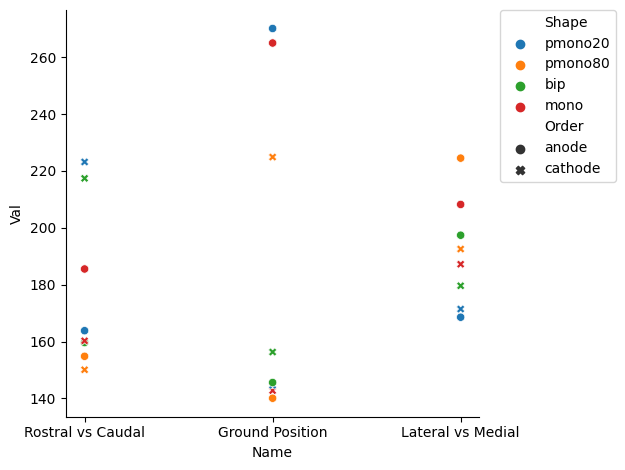

In [62]:
sns.scatterplot(data=df, x="Name", y="Val", hue = "Shape", style = "Order")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [63]:
"L-M" in "R-C bip"

False

In [64]:
"M-L" in "R-C bip"

False

In [65]:

combinations_no_response


[('amap04', '-C6L', '20-0-80-25'),
 ('amap06', 'C6L-C7L', '80-0-20-400'),
 ('amap05', 'C6L-C7L', '20-0-80-25'),
 ('amap08', 'C7L-C6L', '20-0-80-25'),
 ('amap01', 'C7L-', '20-0-80-25'),
 ('amap08', 'C7L-', '20-0-80-25'),
 ('amap06', 'C7L-', '50-0-50-0'),
 ('amap03', 'C8L-C7L', '50-0-50-0'),
 ('amap01', 'C8L-C8M', '50-0-50-0'),
 ('amap08', 'C6L-C6M', '80-0-20-400'),
 ('amap02', 'C8L-C7L', '80-0-20-400'),
 ('amap08', '-C7L', '50-0-50-0'),
 ('amap07', 'C7L-C6L', '50-0-50-100'),
 ('amap04', '-C7L', '20-0-80-25'),
 ('amap02', 'C7L-C7M', '50-0-50-0'),
 ('amap05', 'C7L-', '20-0-80-25'),
 ('amap05', 'C6L-C6M', '80-0-20-400'),
 ('amap07', 'C6L-C6M', '50-0-50-100'),
 ('amap05', 'C7M-C7L', '50-0-50-100'),
 ('amap03', 'C7M-C7L', '20-0-80-25'),
 ('amap02', 'C7L-C8L', '50-0-50-0'),
 ('amap05', 'C6M-C6L', '80-0-20-400'),
 ('amap06', 'C6L-', '80-0-20-400'),
 ('amap06', '-C6L', '20-0-80-25'),
 ('amap05', 'C7L-C6L', '50-0-50-0'),
 ('amap05', 'C6L-', '20-0-80-25'),
 ('amap08', 'C7M-C7L', '50-0-50-0'),
 ('

## Function for matrix

In [66]:
# sns.heatmap

#give rat, muscle, level and keep only those in combinations no response
def hm (*args):
    #args is rat,level,muscle

    combo_no_response = [(c[0], c[1], c[2],c[3]) for c in combo]
    combo_no_response = set(combo_no_response)
    combo_no_response = list(combo_no_response)
    if "amap" in args[0]:
        combo_no_response = [c for c in combo_no_response if c[0] == args[0] and c[1] == args[1] and c[3] == args[2]]
    elif "C" in args[0]:
        combo_no_response = [c for c in combo_no_response if args[0] in c[1] and c[0] == args[1] and c[3] == args[2]]
    combo_no_response = sorted(combo_no_response, key=lambda x: x[2])
    
    sem = []
    diffs = []
    pr = []
    shape_list = list(set(s[2] for s in combo))
    for c in combo_no_response:
        c1 = combo[(c)]["a"]
        for ct in combo_no_response:
        
            c2 = combo[(ct)]["a"]
            
            diffs.append(c1.mean() - c2.mean())
            sem.append((c1-c2).reshape(-1,).std()*2)
            pr.append((c1 < c2).mean())

    diffs = np.array(diffs).reshape(len(combo_no_response),len(combo_no_response))
    sem = np.array(sem).reshape(len(combo_no_response),len(combo_no_response))
    pr = np.array(pr).reshape(len(combo_no_response),len(combo_no_response))

    positive_counts = (diffs > 0).sum(axis=1)
    sorted_indices = np.argsort(positive_counts)
    sorted_data = diffs[sorted_indices][:,sorted_indices]
    sorted_sem = sem[sorted_indices][:,sorted_indices]

    labs = [c[1] + " "+ c[2] for c in combo_no_response]
    for i in range(len(labs)):
        if "50-0-50-100" in labs[i]:
            labs[i] = labs[i].replace("50-0-50-100", "Bipolar")
        elif "50-0-50-0" in labs[i]:
            labs[i] = labs[i].replace("50-0-50-0", "Monopolar")
        elif "80-0-20-400" in labs[i]:
            labs[i] = labs[i].replace("80-0-20-400", "Mono P80")
        elif "20-0-80-25" in labs[i]:
            labs[i] = labs[i].replace("20-0-80-25", "Mono P20")
    sorted_labs = [labs[i] for i in sorted_indices]

    top25 = len(sorted_indices)/4
    top25 = [labs[i] for i in sorted_indices[:int(top25)]]
    bottom25 = len(sorted_indices)/4
    bottom25 = [labs[i] for i in sorted_indices[-int(bottom25):]]

    # labs = [c[1]+" " + c[2] for c in combo_no_response]
    # sorted_labs = [labs[i] for i in sorted_indices]
    # reps = {"50-0-50-100":"Bipolar", "50-0-50-0":"Monopolar", "80-0-20-400":"Mono P80", "20-0-80-25":"Mono P20"}
    # labs = ([reps.get(x,x) for x in labs])
    mask = (abs(sorted_data) < abs(sorted_sem)) | (abs(sorted_data) == abs(sorted_sem))
    masked_data = np.where(mask, np.nan, sorted_data)

    titl = f"{args[0]}, {args[1]}, {args[2]}"
    plt.figure(figsize=(24, 20))
    fig, axes = plt.subplots(
        nrows=1, ncols=1, figsize=(20, 20),
        constrained_layout=True, squeeze=False
    )
    ax = axes[0, 0]
    # ax = sns.heatmap(sorted_data,cmap="bwr", annot=True, xticklabels=sorted_labs, yticklabels=sorted_labs)
    sns.heatmap(masked_data,cmap="bwr", annot=masked_data, xticklabels=sorted_labs, yticklabels=sorted_labs, annot_kws={'va':'bottom'}, ax=ax)
    sns.heatmap(masked_data,cmap="bwr", annot=sorted_sem, xticklabels=sorted_labs, yticklabels=sorted_labs, annot_kws={'va':'top'}, ax=ax, cbar=False, mask = mask)
    # sns.heatmap(sorted_data,cmap="bwr", annot=pr, xticklabels=sorted_labs, yticklabels=sorted_labs, annot_kws={'va':'top'}, ax=ax, cbar=False)
    ax.set(title= titl)

    for (i, j), val in np.ndenumerate(sorted_data):
        if mask[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))

    SL = {
        "Bipolar":"blue", 
        "Monopolar":"Red", 
        "Mono P80":"orange", 
        "Mono P20":"purple"
        }
    

    # Apply color to y labels based on the condition
    for label in ax.get_yticklabels():
        for k, c in SL.items():
            if k in label.get_text():
                label.set_color(c)
                break

    # Apply color to x labels based on the condition (assuming symmetrical conditions)
    for label in ax.get_xticklabels():
        for k, c in SL.items():
            if k in label.get_text():
                label.set_color(c)
                break

    # plt.show()
    plt.close()
    return top25, bottom25, fig, sorted_labs
    

In [67]:
# Iterate through combos and get top 25 and bottom 25
top25 = []
bottom25 = []
position = list(set(s[1].split("C")[1][0] for s in combo))
position = ["C" + x for x in position]
sorted_labs = []

poss_combo = []
for p in position:
    for k in combo.keys():
        if p in k[1]:
            poss_combo.append([k[0], p, k[3]])

poss_combo = np.unique(poss_combo, axis=0)

for k in poss_combo:
    print(k[0], k[1], k[2])
    # a,b, fig, sorted_lab = hm(k[1], k[0], k[2])
    # sorted_lab = [(k[0], k[2], sorted_lab)]
    # sorted_labs.extend(sorted_lab)
    # top25.extend(a)
    # bottom25.extend(b)
    # fig.savefig(f"/home/andres/test{k[0]}_{k[1]}_{k[2]}.png")

amap01 C7 LADM
amap01 C7 LBiceps
amap01 C7 LDeltoid
amap01 C7 LECR
amap01 C7 LFCR
amap01 C7 LTriceps
amap01 C8 LADM
amap01 C8 LBiceps
amap01 C8 LDeltoid
amap01 C8 LECR
amap01 C8 LFCR
amap01 C8 LTriceps
amap02 C7 LADM
amap02 C7 LBiceps
amap02 C7 LDeltoid
amap02 C7 LECR
amap02 C7 LFCR
amap02 C7 LTriceps
amap02 C8 LADM
amap02 C8 LBiceps
amap02 C8 LDeltoid
amap02 C8 LECR
amap02 C8 LFCR
amap02 C8 LTriceps
amap03 C7 LADM
amap03 C7 LBiceps
amap03 C7 LDeltoid
amap03 C7 LECR
amap03 C7 LFCR
amap03 C7 LTriceps
amap03 C8 LADM
amap03 C8 LBiceps
amap03 C8 LDeltoid
amap03 C8 LECR
amap03 C8 LFCR
amap03 C8 LTriceps
amap04 C6 LADM
amap04 C6 LBiceps
amap04 C6 LDeltoid
amap04 C6 LECR
amap04 C6 LFCR
amap04 C6 LTriceps
amap04 C7 LADM
amap04 C7 LBiceps
amap04 C7 LDeltoid
amap04 C7 LECR
amap04 C7 LFCR
amap04 C7 LTriceps
amap05 C6 LADM
amap05 C6 LBiceps
amap05 C6 LDeltoid
amap05 C6 LECR
amap05 C6 LFCR
amap05 C6 LTriceps
amap05 C7 LADM
amap05 C7 LBiceps
amap05 C7 LDeltoid
amap05 C7 LECR
amap05 C7 LFCR
amap05 C7

In [68]:
data = sorted_labs
data_frame = pd.DataFrame(data, columns=['Subject', 'Muscle', 'Ranks'])
data_frame

for m in data_frame.Muscle.unique():
    sns.catplot(data=data_frame, x="Subject", y="Ranks", hue="Muscle", kind="point")

In [69]:
#variable for ranks
Ranks = []
targs = sorted_labs[0][2]
for t in targs:
    print(t)
    for i in range(len(sorted_labs)):
        my_list = sorted_labs[i][2]
        if t in my_list:
            Rank = [t,(my_list.index(t)),sorted_labs[i][1], sorted_labs[i][0]]
            Ranks.append(Rank)

Ranks

IndexError: list index out of range

In [ ]:
sorted_labs

[]

In [ ]:
Ranks

[['C7M-C7L Monopolar', 19, 'LADM', 'amap01'],
 ['C7M-C7L Monopolar', 20, 'LBiceps', 'amap01'],
 ['C7M-C7L Monopolar', 22, 'LDeltoid', 'amap01'],
 ['C7M-C7L Monopolar', 22, 'LECR', 'amap01'],
 ['C7M-C7L Monopolar', 20, 'LFCR', 'amap01'],
 ['C7M-C7L Monopolar', 17, 'LTriceps', 'amap01'],
 ['C7M-C7L Monopolar', 20, 'LADM', 'amap02'],
 ['C7M-C7L Monopolar', 17, 'LBiceps', 'amap02'],
 ['C7M-C7L Monopolar', 19, 'LDeltoid', 'amap02'],
 ['C7M-C7L Monopolar', 18, 'LECR', 'amap02'],
 ['C7M-C7L Monopolar', 19, 'LFCR', 'amap02'],
 ['C7M-C7L Monopolar', 21, 'LTriceps', 'amap02'],
 ['C7M-C7L Monopolar', 18, 'LADM', 'amap03'],
 ['C7M-C7L Monopolar', 18, 'LBiceps', 'amap03'],
 ['C7M-C7L Monopolar', 19, 'LDeltoid', 'amap03'],
 ['C7M-C7L Monopolar', 16, 'LECR', 'amap03'],
 ['C7M-C7L Monopolar', 19, 'LFCR', 'amap03'],
 ['C7M-C7L Monopolar', 20, 'LTriceps', 'amap03'],
 ['C7M-C7L Monopolar', 20, 'LADM', 'amap04'],
 ['C7M-C7L Monopolar', 18, 'LBiceps', 'amap04'],
 ['C7M-C7L Monopolar', 21, 'LDeltoid', 'amap

In [70]:
for t in targs:
    print(t)

NameError: name 'targs' is not defined

In [71]:
data = Ranks
data_frame = pd.DataFrame(data, columns=['Subject', 'Ranks', 'Muscle', 'SubjectID'])
data_frame

# for m in data_frame.Muscle.unique():
#     g = sns.catplot(data=data_frame, x="SubjectID", y="Ranks", hue="Subject", kind="point").set(title = f"{m}")

def plot_ranks(*args):
    #data_frame, muscle)
    muscles = ['LADM', 'LBiceps', 'LDeltoid', 'LECR', 'LFCR', 'LTriceps']
    if args[1] in muscles:
        data = args[0]
        data_filt = data.loc[lambda x: x['Muscle'] == args[1]]
        g = sns.catplot(data=data_filt, x="SubjectID", y="Ranks", hue="Subject", kind="point").set(title = f"{args[1]}")
    else:         
        g = sns.catplot(data=data_frame, x="SubjectID", y="Ranks", hue="Subject", kind="point").set(title = f"{m}")


In [72]:
Ranks.sort(key=lambda x: x[3])
Ranks

[]

In [73]:
plot_ranks(data_frame, 'LADM')

ValueError: min() arg is an empty sequence

In [74]:
#Get the number of occurances for top and bottom 25%
top25_copy = set(top25)
top25_copy
sorted(top25)
top_occurances = []
for i in top25_copy:
    tempcout = top25.count(i)
    top_occurances.append([i, tempcout]) #, tempcout)

top25 = sorted(top_occurances, key=lambda x: x[1], reverse=True)

bottom25_copy = set(bottom25)
sorted(bottom25)
bot_occurances = []
for i in bottom25_copy:
    tempcout = bottom25.count(i)
    bot_occurances.append([i, tempcout]) #, tempcout)

bottom25 = sorted(bot_occurances, key=lambda x: x[1], reverse=True)

<BarContainer object of 0 artists>

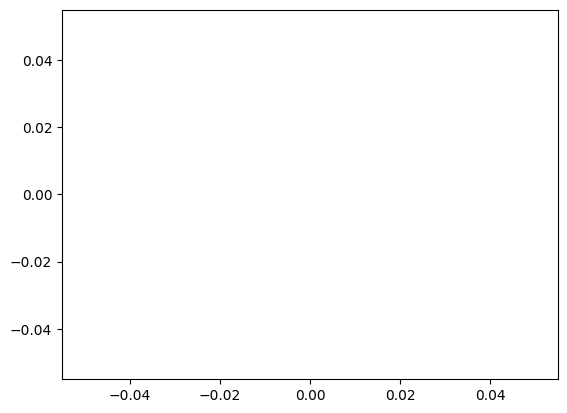

In [75]:
x = []
y = []
for i in top25:
    x = x.append(i[0])
    y = y.append(i[1])
plt.bar(x,y)

In [ ]:
top25

[]

In [ ]:
a,b,g = hm("C8", "amap06","LADM")


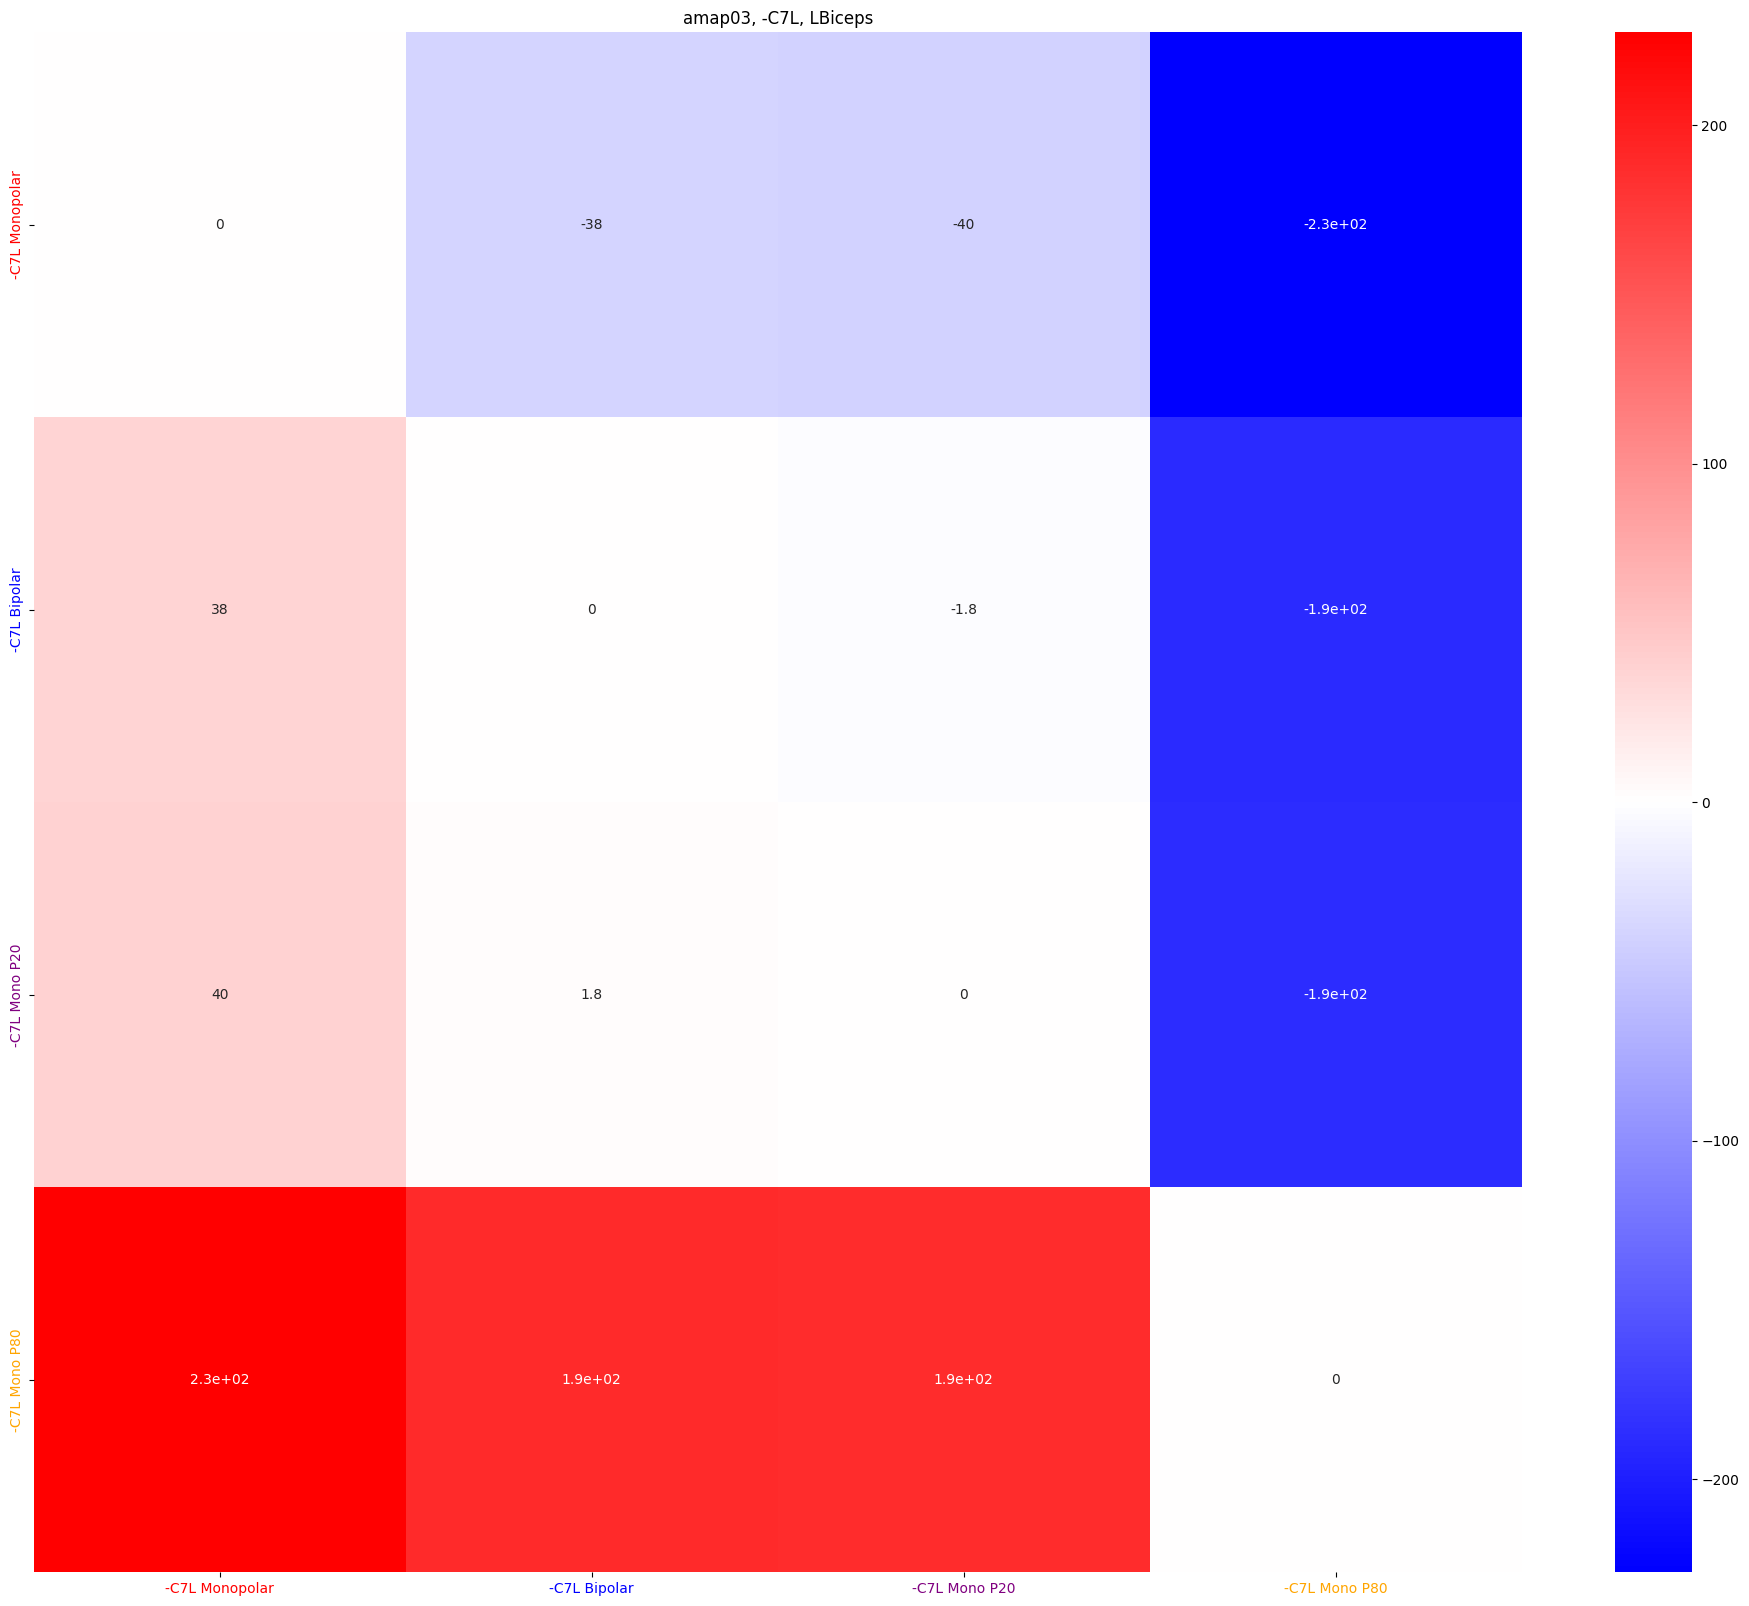

In [ ]:
hm("amap03","-C7L","LBiceps")